In [197]:
import numpy as np
import numpy.linalg as npl
import scipy.linalg as spl
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d as plt3d
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

### Résolution du problème 1D, avec conditions de Dirichlet homogènes

In [198]:
#Mesh definition
xm = 0
xM = 1

ym = 0
yM = 1
y0 = 1/2

N = 2*25 # 100 points selon x, 50 sur y sous la disc et 50 sur y sur la disc

h = (xM - xm) / (N)

MeshM = np.meshgrid(np.linspace(xm, xM, N), np.linspace(y0, yM, int(N/2)))
Meshm = np.meshgrid(np.linspace(xm, xM, N), np.linspace(ym, y0, int(N/2)))

#InM = (MeshM[0][ 1:-1, 1:-1], MeshM[1][ 1:-1, 1:-1])
#Inm = (Meshm[0][ 1:-1, 1:-1], Meshm[1][ 1:-1, 1:-1])


In [199]:
#function definition
#def a(x, y):
#    return (x - .5)**2 + (y - .5)**2
def a(x, y):
    return 1

def f(x, y):
    return np.exp(-(x-1/2)**2 -(y-1/2)**2)

Beta = 1    

U = np.zeros((N, N))

In [200]:
def quadrature(f, a, b, c): # A TESTER


    c1 = (a[0] - b[0])**2 + (a[1] - b[1])**2
    c2 = (a[0] - c[0])**2 + (a[1] - c[1])**2
    c3 = (b[0] - c[0])**2 + (b[1] - c[1])**2
    p = c1 + c2 + c3      #perimetre
    aire = np.sqrt(p*(p - c1)*(p - c2)*(p - c3)) 

    p1 = f((a[0] + b[0] + 3*c[0])/5, (a[1] + b[1] + 3*c[1])/5)
    p2 = f((a[0] + 3*b[0] + c[0])/5, (a[1] + 3*b[1] + c[1])/5)
    p3 = f((3*a[0] + b[0] + c[0])/5, (3*a[1] + b[1] + c[1])/5)
    
    
    intval = (25/48) * (p1 + p2 + p3) * aire

    return intval

In [201]:
#calcul du produit scalaire quand i==j, cad sur la diagonale

def ScalarProductOverlap(f, M_x, M_y, h):  # f function (a), M1 M2 les points autours des quels Phi_i et Phi_j sont centrés.
    
    T = np.zeros(M_x[ 1:-1, 1:-1].shape)
    # right = np.array([h, 0])
    # high = np.array([0, h])

    # print(quadrature(f, M,  M + left, M + left + down )
    # T+= quadrature(f, M,  M + left, M + left + down ) #T1 : centre , gauche et bas gauche
    # T+= quadrature(f, M,  M + down , M + left + down ) #T2 : centre , bas et diagonale basse
    # T+= quadrature(f, M,  M + down, M + right )         #T3 : centre , bas et droite
    # T+= quadrature(f, M,  M + right, M + right + high ) #T4 : centre , haut droit et droite
    # T+= quadrature(f, M,  M + high, M + right + high )  #T5 : centre , haut droit et haut
    # T+= quadrature(f, M,  M + left, M + high )         #T6 : centre , haut et gauche
    M = np.array([M_x, M_y])

    T+= quadrature(f, (M_x[ 1:-1, 1:-1], M_y[ 1:-1, 1:-1]), (M_x[ 1:-1, :-2], M_y[ 1:-1, :-2]), (M_x[2:,:-2], M_y[2:,:-2])) #T1 : centre , gauche et bas gauche
    T+= quadrature(f, (M_x[ 1:-1, 1:-1], M_y[ 1:-1, 1:-1]), (M_x[ 2:, 1:-1], M_y[ 2:, 1:-1]), (M_x[2:,:-2], M_y[2:,:-2])) #T2 : centre , bas et bas gauche
    T+= quadrature(f, (M_x[ 1:-1, 1:-1], M_y[ 1:-1, 1:-1]), (M_x[ 2:, 1:-1], M_y[ 2:, 1:-1]), (M_x[1:-1,2:], M_y[1:-1,2:])) #T3 : centre , bas et droite
    T+= quadrature(f, (M_x[ 1:-1, 1:-1], M_y[ 1:-1, 1:-1]), (M_x[ :-2, 2:], M_y[ :-2, 2:]), (M_x[1:-1,2:], M_y[1:-1,2:])) #T4 : centre , haut droit et droite
    T+= quadrature(f, (M_x[ 1:-1, 1:-1], M_y[ 1:-1, 1:-1]), (M_x[ :-2, 2:], M_y[ :-2, 2:]), (M_x[:-2,1:-1], M_y[:-2,1:-1])) #T5 : centre , haut droit et haut
    T+= quadrature(f, (M_x[ 1:-1, 1:-1], M_y[ 1:-1, 1:-1]), (M_x[ 1:-1, :-2], M_y[ 1:-1, :-2]), (M_x[:-2,1:-1], M_y[:-2,1:-1]))  #T6 : centre , gauche et haut

    return T

In [202]:
def ScalarProductSideOverlap(f, M_x, M_y, h, side):  # f function (a), M1 M2 les points autours des quels Phi_i et Phi_j sont centrés.
    T = np.zeros(M_x[ 1:-1, 1:-1].shape) #on calcul pour tous les ponts interieurs

    if side=="right": #on a zéro sur le bord vers leqeul on décale car pas dirichlet homogène
        T+= quadrature(lambda x, y : -f(x, y), (M_x[ 1:-1, 1:-1], M_y[ 1:-1, 1:-1]), (M_x[ :-2, 2:], M_y[ :-2, 2:]), (M_x[1:-1,2:], M_y[1:-1,2:]))  #T4 : centre , droite et haut droit
        T+= quadrature(lambda x, y : -f(x, y), (M_x[ 1:-1, 1:-1], M_y[ 1:-1, 1:-1]), (M_x[ 2:, 1:-1], M_y[ 2:, 1:-1]), (M_x[1:-1,2:], M_y[1:-1,2:])) #T3 : centre , bas et droite
        T[:, -1] =0
    elif side=="left":
        T+= quadrature(lambda x, y : -f(x, y), (M_x[ 1:-1, 1:-1], M_y[ 1:-1, 1:-1]), (M_x[ 1:-1, :-2], M_y[ 1:-1, :-2]), (M_x[2:,:-2], M_y[2:,:-2])) #T1 : centre , gauche et bas gauche
        T+= quadrature(lambda x, y : -f(x, y), (M_x[ 1:-1, 1:-1], M_y[ 1:-1, 1:-1]), (M_x[ 1:-1, :-2], M_y[ 1:-1, :-2]), (M_x[:-2,1:-1], M_y[:-2,1:-1]))  #T6 : centre , gauche et haut
        T[:, 0] =0
    
    return T

In [203]:
def ScalarProductVerticalOverlap(f, M_x, M_y, h, side):  # f function (a), M1 M2 les points autours des quels Phi_i et Phi_j sont centrés.
    T = np.zeros(M_x[ 1:-1, 1:-1].shape)

    if side=="haut":
        T+= quadrature(lambda x, y : -f(x, y), (M_x[ 1:-1, 1:-1], M_y[ 1:-1, 1:-1]), (M_x[ :-2, 2:], M_y[ :-2, 2:]), (M_x[:-2,1:-1], M_y[:-2,1:-1])) #T5 : centre , haut droit et haut
        T+= quadrature(lambda x, y : -f(x, y), (M_x[ 1:-1, 1:-1], M_y[ 1:-1, 1:-1]), (M_x[ 1:-1, :-2], M_y[ 1:-1, :-2]), (M_x[:-2,1:-1], M_y[:-2,1:-1]))  #T6 : centre , gauche et haut
        T[-1,:] = 0 #INVERSION POSSIBLE ICI
    elif side=="bas":
        T+= quadrature(lambda x, y : -f(x, y), (M_x[ 1:-1, 1:-1], M_y[ 1:-1, 1:-1]), (M_x[ 2:, 1:-1], M_y[ 2:, 1:-1]), (M_x[2:,:-2], M_y[2:,:-2])) #T2 : centre , bas et bas gauche
        T+= quadrature(lambda x, y : -f(x, y), (M_x[ 1:-1, 1:-1], M_y[ 1:-1, 1:-1]), (M_x[ 2:, 1:-1], M_y[ 2:, 1:-1]), (M_x[1:-1,2:], M_y[1:-1,2:])) #T3 : centre , bas et droite
        T[0,:] = 0

    return T

In [204]:
def Continuous_Part(Mesh):

    Nx = Mesh[0].shape[1]
    Ny = Mesh[0].shape[0]

    h = (xM - xm) / (N + 1)

    C = np.zeros(( (Nx - 2) * (Ny - 2), (Nx - 2) * (Ny - 2)))

    AllScalarProductCentre =  ScalarProductOverlap(a, Mesh[0], Mesh[1], h)/(h**2)
    C += np.diag(np.ravel(AllScalarProductCentre))

    AllScalarProductSide = ScalarProductSideOverlap(a, Mesh[0], Mesh[1], h, "right")/(h**2) #on calcule tous les produits scalaires entre deux noeuds voisins à droite

    C += np.diag(np.ravel(AllScalarProductSide)[:-1], 1)     
    C += np.diag(np.ravel(AllScalarProductSide)[:-1], -1)     


    AllScalarProductVertical = ScalarProductVerticalOverlap(a, Mesh[0], Mesh[1], h, "haut")/(h**2) 

    C += np.diag(np.ravel( AllScalarProductVertical  )[:-Nx], Nx)   #il faut enlever ceux calculé en trop sur le haut et le bas PEUT ETRE UNE INVERSION ICI
    C += np.diag(np.ravel( AllScalarProductVertical  )[Nx:], -Nx)  #idem 


    return C

In [205]:
def Mat_Sys(MeshM, Meshm):

    
    Nx = MeshM[0].shape[1]
    Nym = Meshm[1].shape[0]   
    NyM = MeshM[1].shape[0]
    Ny = Nym + NyM

    C = np.zeros(((Nx-2)*(Ny-2), (Nx-2)*(Ny-2)))

    # On remplit chaque coin de la matrice

    C[:(Nx-2)*(Nym-2), :(Nx-2)*(Nym-2)] = Continuous_Part(Meshm) 
    C[-(Nx-2)*(NyM-2):, -(Nx-2)*(NyM-2):] = Continuous_Part(MeshM)

    # On remplit la croix centrale


    #carré centrale
    #square = np.diag(Beta*np.ones(2*(Nx-2)))
    square = np.zeros((2*(Nx-2), 2*(Nx-2)))
    square += np.diag(-Beta*np.ones((Nx-2)), Nx-2)
    square += np.diag(-Beta*np.ones((Nx-2)), -Nx+2)

    C[(Nx-2)*(Nym-2):-(Nx-2)*(NyM-2), (Nx-2)*(Nym-2):-(Nx-2)*(NyM-2)] = square



    return C


In [210]:
print(Mat_Sys(Meshm, MeshM).shape)
np.savetxt("matrice", Mat_Sys(Meshm, MeshM))


(2304, 2304)


In [207]:
def ScalarProductSM(f, M_x, M_y, h):
    
    T = np.zeros(M_x[ 1:-1, 1:-1].shape)

    T+= quadrature(lambda x, y : f(x, y) * (x/h + 1 - M_x[ 1:-1, 1:-1]/h), (M_x[ 1:-1, 1:-1], M_y[ 1:-1, 1:-1]), (M_x[ 1:-1, :-2], M_y[ 1:-1, :-2]), (M_x[2:,:-2], M_y[2:,:-2])) #T1 : centre , gauche et bas gauche
    T+= quadrature(lambda x, y : f(x, y) * (y/h + 1 - M_y[ 1:-1, 1:-1]/h), (M_x[ 1:-1, 1:-1], M_y[ 1:-1, 1:-1]), (M_x[ 2:, 1:-1], M_y[ 2:, 1:-1]), (M_x[2:,:-2], M_y[2:,:-2])) #T2 : centre , bas et bas gauche
    T+= quadrature(lambda x, y : f(x, y) * (-x/h + y/h + 1), (M_x[ 1:-1, 1:-1], M_y[ 1:-1, 1:-1]), (M_x[ 2:, 1:-1], M_y[ 2:, 1:-1]), (M_x[1:-1,2:], M_y[1:-1,2:])) #T3 : centre , bas et droite
    T+= quadrature(lambda x, y : f(x, y) * (-x/h + 1 + M_x[ 1:-1, 1:-1]/h), (M_x[ 1:-1, 1:-1], M_y[ 1:-1, 1:-1]), (M_x[ :-2, 2:], M_y[ :-2, 2:]), (M_x[1:-1,2:], M_y[1:-1,2:])) #T4 (6 en fait) : centre , haut droit et droite
    T+= quadrature(lambda x, y : f(x, y) * (-y/h + 1 + M_y[ 1:-1, 1:-1]/h), (M_x[ 1:-1, 1:-1], M_y[ 1:-1, 1:-1]), (M_x[ :-2, 2:], M_y[ :-2, 2:]), (M_x[:-2,1:-1], M_y[:-2,1:-1])) #T5 : centre , haut droit et haut
    T+= quadrature(lambda x, y : f(x, y) * (x/h - y/h + 1), (M_x[ 1:-1, 1:-1], M_y[ 1:-1, 1:-1]), (M_x[ 1:-1, :-2], M_y[ 1:-1, :-2]), (M_x[:-2,1:-1], M_y[:-2,1:-1]))  #T6 (4 en fait) : centre , gauche et haut

    return T

def ScalarProductSMbas(f, M_x, M_y, h):
    
    T = np.zeros(M_x.shape[1] - 2)

    T+= quadrature(lambda x, y : f(x, y) * (x/h + 1 - M_x[ 1, 1:-1]/h), (M_x[ 1, 1:-1], M_y[ 1, 1:-1]), (M_x[ 1, :-2], M_y[ 1, :-2]), (M_x[0,:-2], M_y[0,:-2])) #T1 : centre , gauche et bas gauche
    T+= quadrature(lambda x, y : f(x, y) * (y/h + 1 - M_y[ 1, 1:-1]/h), (M_x[ 1, 1:-1], M_y[ 1, 1:-1]), (M_x[ 0, 1:-1], M_y[ 0, 1:-1]), (M_x[0,:-2], M_y[0,:-2])) #T2 : centre , bas et bas gauche
    T+= quadrature(lambda x, y : f(x, y) * (-x/h + y/h + 1), (M_x[ 1, 1:-1], M_y[ 1, 1:-1]), (M_x[0, 1:-1], M_y[ 0, 1:-1]), (M_x[1,2:], M_y[1,2:])) #T3 : centre , bas et droite

    return T

def ScalarProductSMhaut(f, M_x, M_y, h):
    
    T = np.zeros(M_x.shape[1] - 2)

    T+= quadrature(lambda x, y : f(x, y) * (-x/h + 1 + M_x[ 0, 1:-1]/h), (M_x[ 0, 1:-1], M_y[ 0, 1:-1]), (M_x[ 1, 2:], M_y[ 1, 2:]), (M_x[0,2:], M_y[0,2:])) #T4 (6 en fait) : centre , haut droit et droite
    T+= quadrature(lambda x, y : f(x, y) * (-y/h + 1 + M_y[ 0, 1:-1]/h), (M_x[ 0, 1:-1], M_y[ 0, 1:-1]), (M_x[ 1, 2:], M_y[ 1, 2:]), (M_x[1,1:-1], M_y[1,1:-1])) #T5 : centre , haut droit et haut
    T+= quadrature(lambda x, y : f(x, y) * (x/h - y/h + 1), (M_x[ 0, 1:-1], M_y[ 0, 1:-1]), (M_x[ 0, :-2], M_y[ 0, :-2]), (M_x[1,1:-1], M_y[1,1:-1]))  #T6 (4 en fait) : centre , gauche et haut

    return T

def Sec_Mem(f, Meshm, MeshM):

    Nx = MeshM[0].shape[1]
    Nym = Meshm[1].shape[0]   
    NyM = MeshM[1].shape[0]

    fm = np.zeros( Nx * Nym)
    fM = np.zeros( Nx * NyM)

    fm = np.ravel(ScalarProductSM(f, Meshm[0], Meshm[1], h))#calcul partout sauf sur la discontinuité
    
    disc = np.zeros(Nx-2)  # -2 car il faut toujours enlever les 2 ponts sur les bords

    disc = np.ravel(ScalarProductSMbas(f, MeshM[0][-2:, :], MeshM[1][-2:, :],  h))  #Je ne prends que les triangles du bas
    disc += np.ravel(ScalarProductSMhaut(f, MeshM[0][:2, :], MeshM[1][:2, :],  h))   #Je ne prends que les triangles du haut

    fM = np.ravel(ScalarProductSM(f, MeshM[0], MeshM[1], h)) #calcul partout sauf sur la discontinuité

    return np.concatenate((np.concatenate((fm, disc)), np.concatenate((disc, fM))))

In [208]:
print("matrice",Mat_Sys(MeshM, Meshm).shape)
print("Sm : ",Sec_Mem(f, Meshm, MeshM).shape)

matrice (2304, 2304)
Sm :  (2304,)


Text(0.5, 0, 'z')

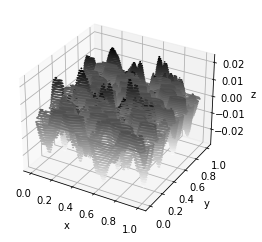

In [209]:

A = csr_matrix(Mat_Sys(MeshM, Meshm))
res = spsolve(A,Sec_Mem(f, Meshm, MeshM))
U[1:-1, 1:-1] = res.reshape((N-2, N-2))  # peut etre un probleme de taille

X = MeshM[0]
Ym = Meshm[1]
YM = MeshM[1]
Zm = U[:Meshm[0].shape[0], :Meshm[0].shape[1]]                 
ZM = U[Meshm[0].shape[0]:, :Meshm[0].shape[1]]                 

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Ym, Zm, 50, cmap='binary')
ax.contour3D(X, YM, ZM, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')